In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [105]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_2, make_FXHedge
from hc_graph import hc_stock

In [134]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']
EUR_rate = pd.read_csv(r"financial_data/EUR_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

#fx
EUR_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['EUR/USD']
GBP_USD_fx = pd.read_csv(r"financial_data/FX_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['GBP/USD']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0, parse_dates=True, dayfirst=True)[['EU_BNPILSNE']].ffill()
hfrx_all = hfrx_all.loc[EUR_rate.index].dropna()
hfrx_all = make_FXHedge(hfrx_all, EUR_USD_fx)
#hfrx = make_ER(hfrx_all[['EU_BNPILSNE']].dropna(), EUR_rate)
bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BPFXEUR1', 'BPFXGBP1']]


bnp_all = pd.read_csv(r"financial_data/guru_ls_tracking.csv", index_col=0, parse_dates=True, dayfirst=True).drop('EU_BNPILSNE', axis =1)
bnp_all = bnp_all.loc[EUR_rate.index]

bnp_all_EUR = make_FXHedge(bnp_all[['EU_BNPIPMEE', 'EU_BNPIPVEE', 'EU_BNPIPQEE','EU_BNPIPLEE', 'EU_BNPIFEU' ]], EUR_USD_fx)
bnp_all_GBP = make_FXHedge(bnp_all[['GB_BNPIFGB']], GBP_USD_fx)
bnp_all = bnp_all[['US_BNPIPMUE', 'US_BNPIPVUE', 'US_BNPIPQUE', 'US_BNPIPLUE', 'US_BNPIFUS']]
bnp_all = bnp_all.join(bnp_all_EUR,how="outer")
bnp_all = bnp_all.join(bnp_all_GBP,how="outer")
bnp_all = bnp_all.join(bnp, how="outer")
#bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
#                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

In [135]:

prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx_all,how="outer")

In [136]:
prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [137]:
hrfx_returns = returns_all[["EU_BNPILSNE"]]
bch_returns_all = returns_all.drop("EU_BNPILSNE", axis=1)

size = 52
freq = 4
bounds = (-np.inf,np.inf)
total_weight = np.nan

df_weight_all = ols_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("EU_BNPILSNE", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices_all.loc[replication_all.index][["EU_BNPILSNE"]]
df_res["OLS all"] = replication_all

In [138]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=0.05)
replication_lasso = make_track(prices_for_track_all, df_weight_lasso)
df_res["Lasso"] = replication_lasso

In [139]:
df_weight_lasso2 = lasso_regression_2(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds,
                                       weight_sum=total_weight, l1=0.04, l2=1.5)
replication_lasso2 = make_track(prices_for_track_all, df_weight_lasso2)
df_res["Lasso 2"] = replication_lasso2
df_res = df_res / df_res.iloc[0]

(0, 1.6932447697185655)

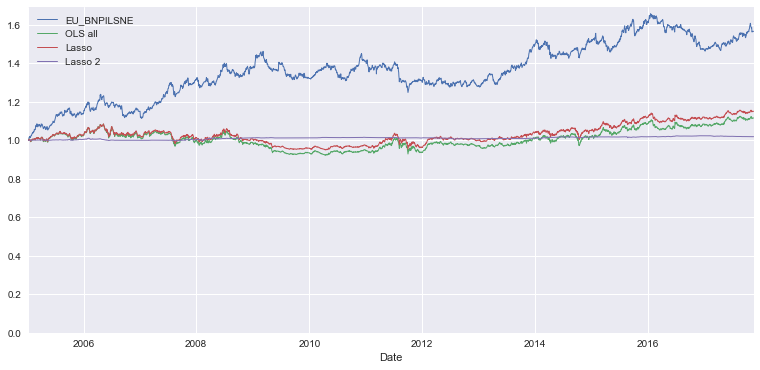

In [140]:
df_res.plot(figsize=(13,6), linewidth=1)
plt.gca().set_ylim(bottom=0)

In [141]:
g = hc_stock(df_res)
g.plot()

In [142]:
Returns = df_res.pct_change().dropna()
Returns.corr(method='pearson')

,EU_BNPILSNE,OLS all,Lasso,Lasso 2
EU_BNPILSNE,1.000000,0.419900,0.421938,0.199033
OLS all,0.419900,1.000000,0.995251,0.334729
Lasso,0.421938,0.995251,1.000000,0.347270
Lasso 2,0.199033,0.334729,0.347270,1.000000


In [143]:
(Returns.mean() / Returns.std()) * np.sqrt(252)

EU_BNPILSNE    0.589410
OLS all        0.195637
Lasso          0.262829
Lasso 2        0.313755
dtype: float64